In [ ]:
!pip install selenium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00


**IMPORTING NECESSARY LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup
from selenium import webdriver
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import pickle
import warnings
warnings.filterwarnings('ignore')

**LOADING THE DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
phish_data = pd.read_csv('drive/MyDrive/phishing_site_urls.csv')

In [ ]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [ ]:
phish_data.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [ ]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [ ]:
phish_data.isnull().sum() # there are no missing values

URL      0
Label    0
dtype: int64

**CREATING A DATAFRAME OF CLASSES COUNT**

In [ ]:
label_counts = pd.DataFrame(phish_data.Label.value_counts())



**CHECKING AND REMOVING DUPLICATES**


In [ ]:
phish_data.URL.duplicated().sum()

42151

In [ ]:
phish_data.drop(phish_data[phish_data.URL.duplicated() == True].index, axis = 0, inplace = True)
phish_data.reset_index(drop=True)

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
507190,23.227.196.215/,bad
507191,apple-checker.org/,bad
507192,apple-iclods.org/,bad
507193,apple-uptoday.org/,bad


**VISUALIZING TARGET COLUMN**

In [ ]:
fig = px.bar(label_counts, x=label_counts.index, y=label_counts.Label)
fig.show()




**HANDLING STOPWORDS**

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))
sw=list(set(stopwords.words("english")))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
phish_data['clean_url']=phish_data.URL.astype(str)
#df['clean_url']=df['clean_url'].apply(lambda x:" ".join([word for word in x.split() if word not in sw]))
phish_data.head()

,URL,Label,clean_url
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,nobell.it/70ffb52d079109dca5664cce6f317373782/...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,serviciosbys.com/paypal.cgi.bin.get-into.herf....
3,mail.printakid.com/www.online.americanexpress....,bad,mail.printakid.com/www.online.americanexpress....
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,thewhiskeydregs.com/wp-content/themes/widescre...


In [ ]:
phish_data.URL.duplicated().sum()

0

**TOKENIZATION**

In [ ]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [ ]:
phish_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [ ]:
tokenizer.tokenize(phish_data.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [ ]:
print('Getting words tokenized ...')
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.clean_url.map(lambda t: tokenizer.tokenize(t))
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 4.777697231000047 sec


In [ ]:
phish_data.sample(5)

,URL,Label,clean_url,text_tokenized
156464,carolinarailhawks.com/index.php?id=111,good,carolinarailhawks.com/index.php?id=111,"[carolinarailhawks, com, index, php, id]"
355682,huffingtonpost.com/alex-remington/ranking-base...,good,huffingtonpost.com/alex-remington/ranking-base...,"[huffingtonpost, com, alex, remington, ranking..."
158836,ckuik.com/Bobby_Jarzombek,good,ckuik.com/Bobby_Jarzombek,"[ckuik, com, Bobby, Jarzombek]"
513312,diafox.xyz/Panel/,bad,diafox.xyz/Panel/,"[diafox, xyz, Panel]"
303637,chezbob.com/,good,chezbob.com/,"[chezbob, com]"


**STEMMING WORDS**

In [ ]:
stemmer = SnowballStemmer("english")

In [ ]:
print('Getting words stemmed ...')
t0= time.perf_counter()
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 49.68881218700005 sec


In [ ]:
phish_data.sample(5)

,URL,Label,clean_url,text_tokenized,text_stemmed
74780,www.pa.msu.edu/ftp/pub/beers/posts/rostat/rost...,good,www.pa.msu.edu/ftp/pub/beers/posts/rostat/rost...,"[www, pa, msu, edu, ftp, pub, beers, posts, ro...","[www, pa, msu, edu, ftp, pub, beer, post, rost..."
122887,urologosdeveracruz.com/doc/doc/processing.html,bad,urologosdeveracruz.com/doc/doc/processing.html,"[urologosdeveracruz, com, doc, doc, processing...","[urologosdeveracruz, com, doc, doc, process, h..."
130519,supersaludable.com.mx/yahoo/Yahoo-2014/yinput/,bad,supersaludable.com.mx/yahoo/Yahoo-2014/yinput/,"[supersaludable, com, mx, yahoo, Yahoo, yinput]","[supersalud, com, mx, yahoo, yahoo, yinput]"
220027,national.ballet.ca/,good,national.ballet.ca/,"[national, ballet, ca]","[nation, ballet, ca]"
87397,news.cnet.com/2100-1014_3-1010607.html,good,news.cnet.com/2100-1014_3-1010607.html,"[news, cnet, com, html]","[news, cnet, com, html]"


**OBTAINING JOINING WORDS**

In [ ]:
print('Getting joiningwords ...')
t0= time.perf_counter()
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.40208781499995894 sec


In [ ]:
phish_data.sample(5)

,URL,Label,clean_url,text_tokenized,text_stemmed,text_sent
429068,secinfo.com/dsvRm.1264.htm,good,secinfo.com/dsvRm.1264.htm,"[secinfo, com, dsvRm, htm]","[secinfo, com, dsvrm, htm]",secinfo com dsvrm htm
60845,home.deds.nl/~svg/,good,home.deds.nl/~svg/,"[home, deds, nl, svg]","[home, ded, nl, svg]",home ded nl svg
35839,allisabourme.h19.ru/ebay.motors.com.2007.Subar...,bad,allisabourme.h19.ru/ebay.motors.com.2007.Subar...,"[allisabourme, h, ru, ebay, motors, com, Subar...","[allisabourm, h, ru, ebay, motor, com, subaru,...",allisabourm h ru ebay motor com subaru impreza...
437307,spokeo.com/Wilson+Parker,good,spokeo.com/Wilson+Parker,"[spokeo, com, Wilson, Parker]","[spokeo, com, wilson, parker]",spokeo com wilson parker
451892,trueknowledge.com/q/facts_about__jane_yolen,good,trueknowledge.com/q/facts_about__jane_yolen,"[trueknowledge, com, q, facts, about, jane, yo...","[trueknowledg, com, q, fact, about, jane, yolen]",trueknowledg com q fact about jane yolen


**VISUALIZING IMPORTANT KEYS USING WORD CLOUD**

In [ ]:
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [ ]:
bad_sites.head()

,URL,Label,clean_url,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,nobell.it/70ffb52d079109dca5664cce6f317373782/...,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,serviciosbys.com/paypal.cgi.bin.get-into.herf....,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,mail.printakid.com/www.online.americanexpress....,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,thewhiskeydregs.com/wp-content/themes/widescre...,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [ ]:
good_sites.head()

,URL,Label,clean_url,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,'www.institutocgr.coo/web/media/syqvem/dk-óij...,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


In [ ]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
      plt.imshow(wordcloud);
      plt.title(title, fontdict={'size': title_size, 'color': 'green','verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

In [ ]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

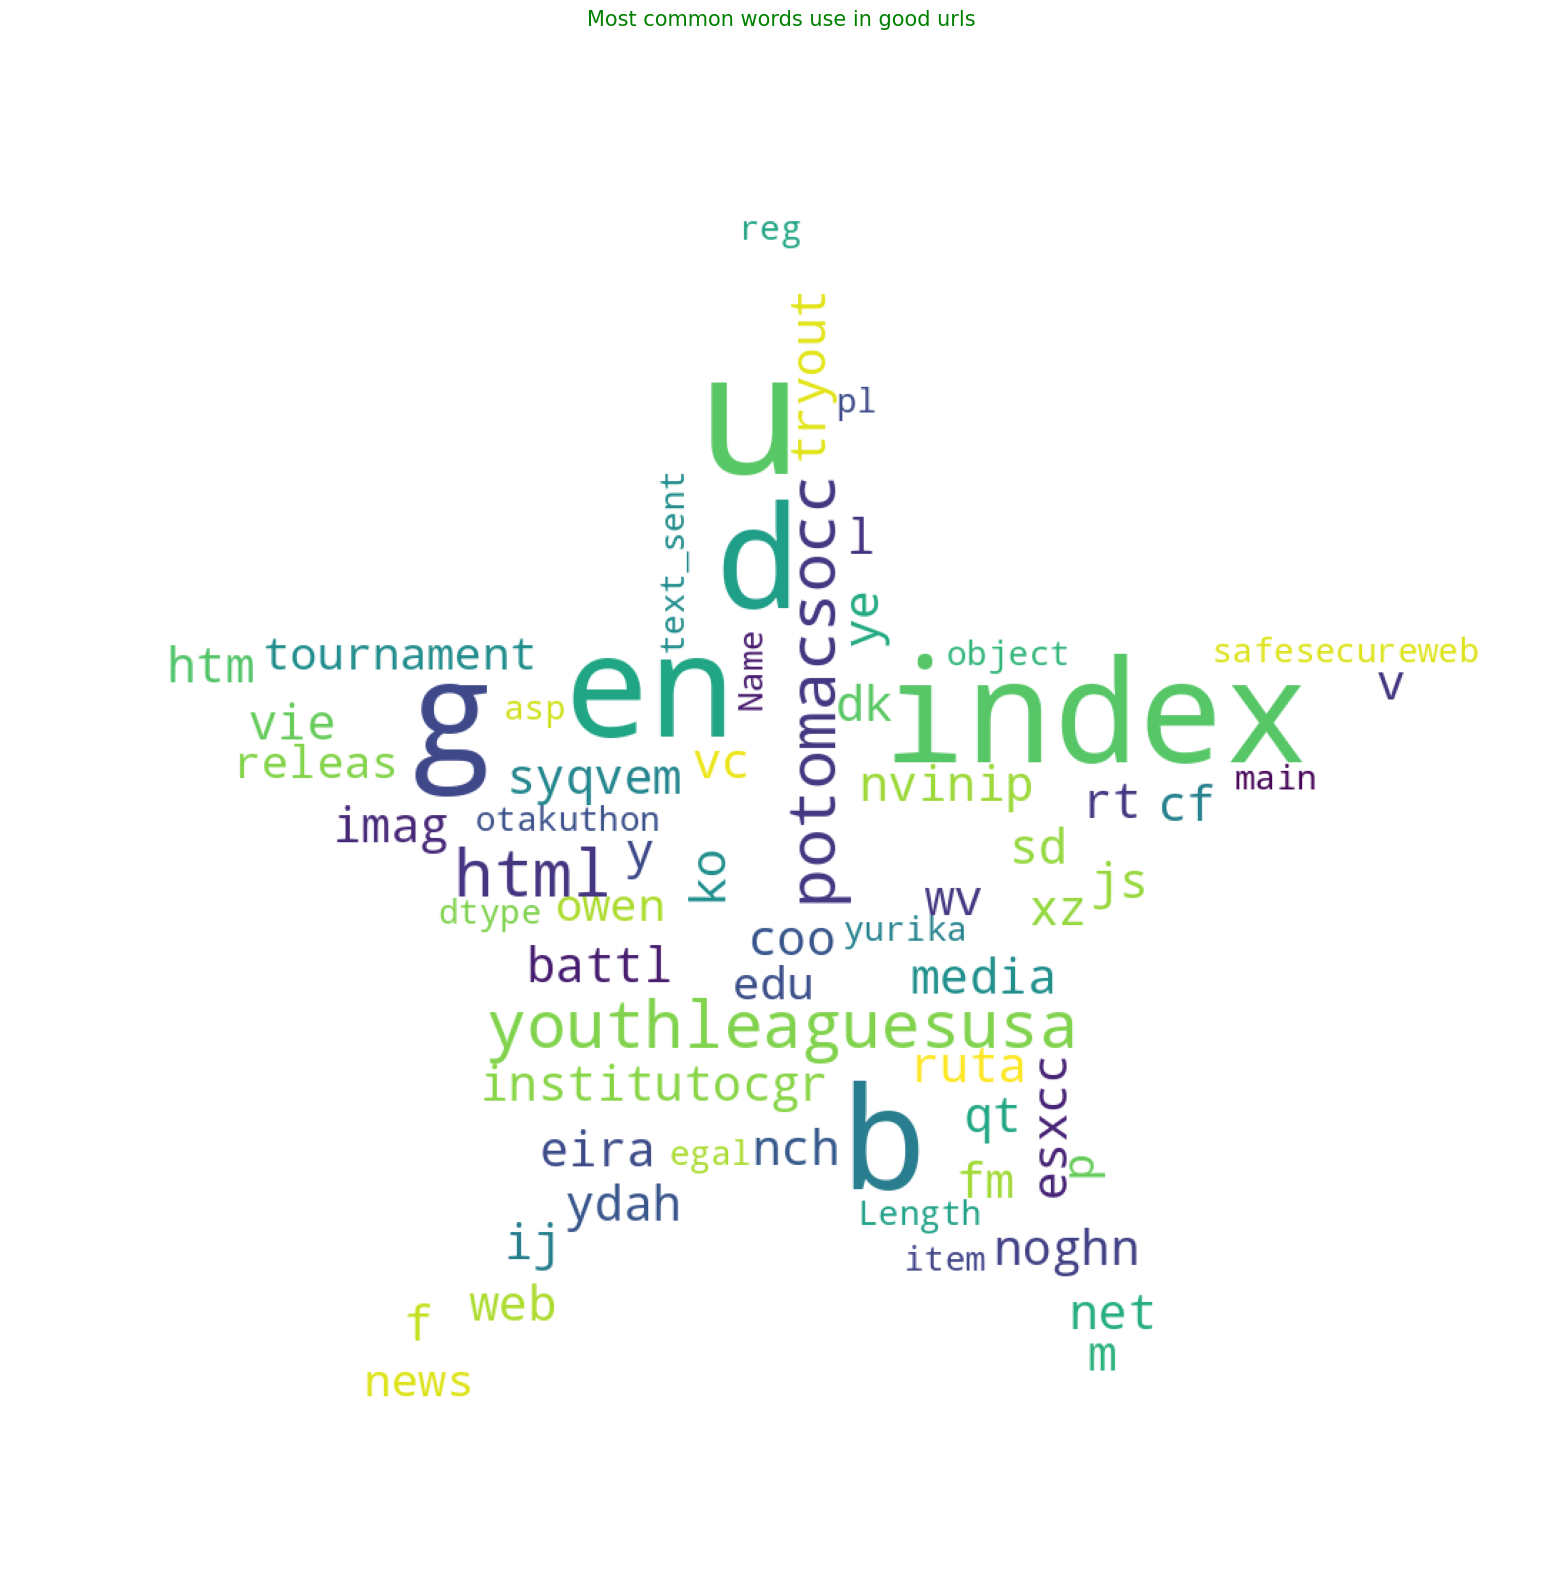

In [ ]:
common_text = str(data)
common_mask = np.array(Image.open('drive/MyDrive/star.png'))
plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120,
               title = 'Most common words use in good urls', title_size=15)#

In [ ]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

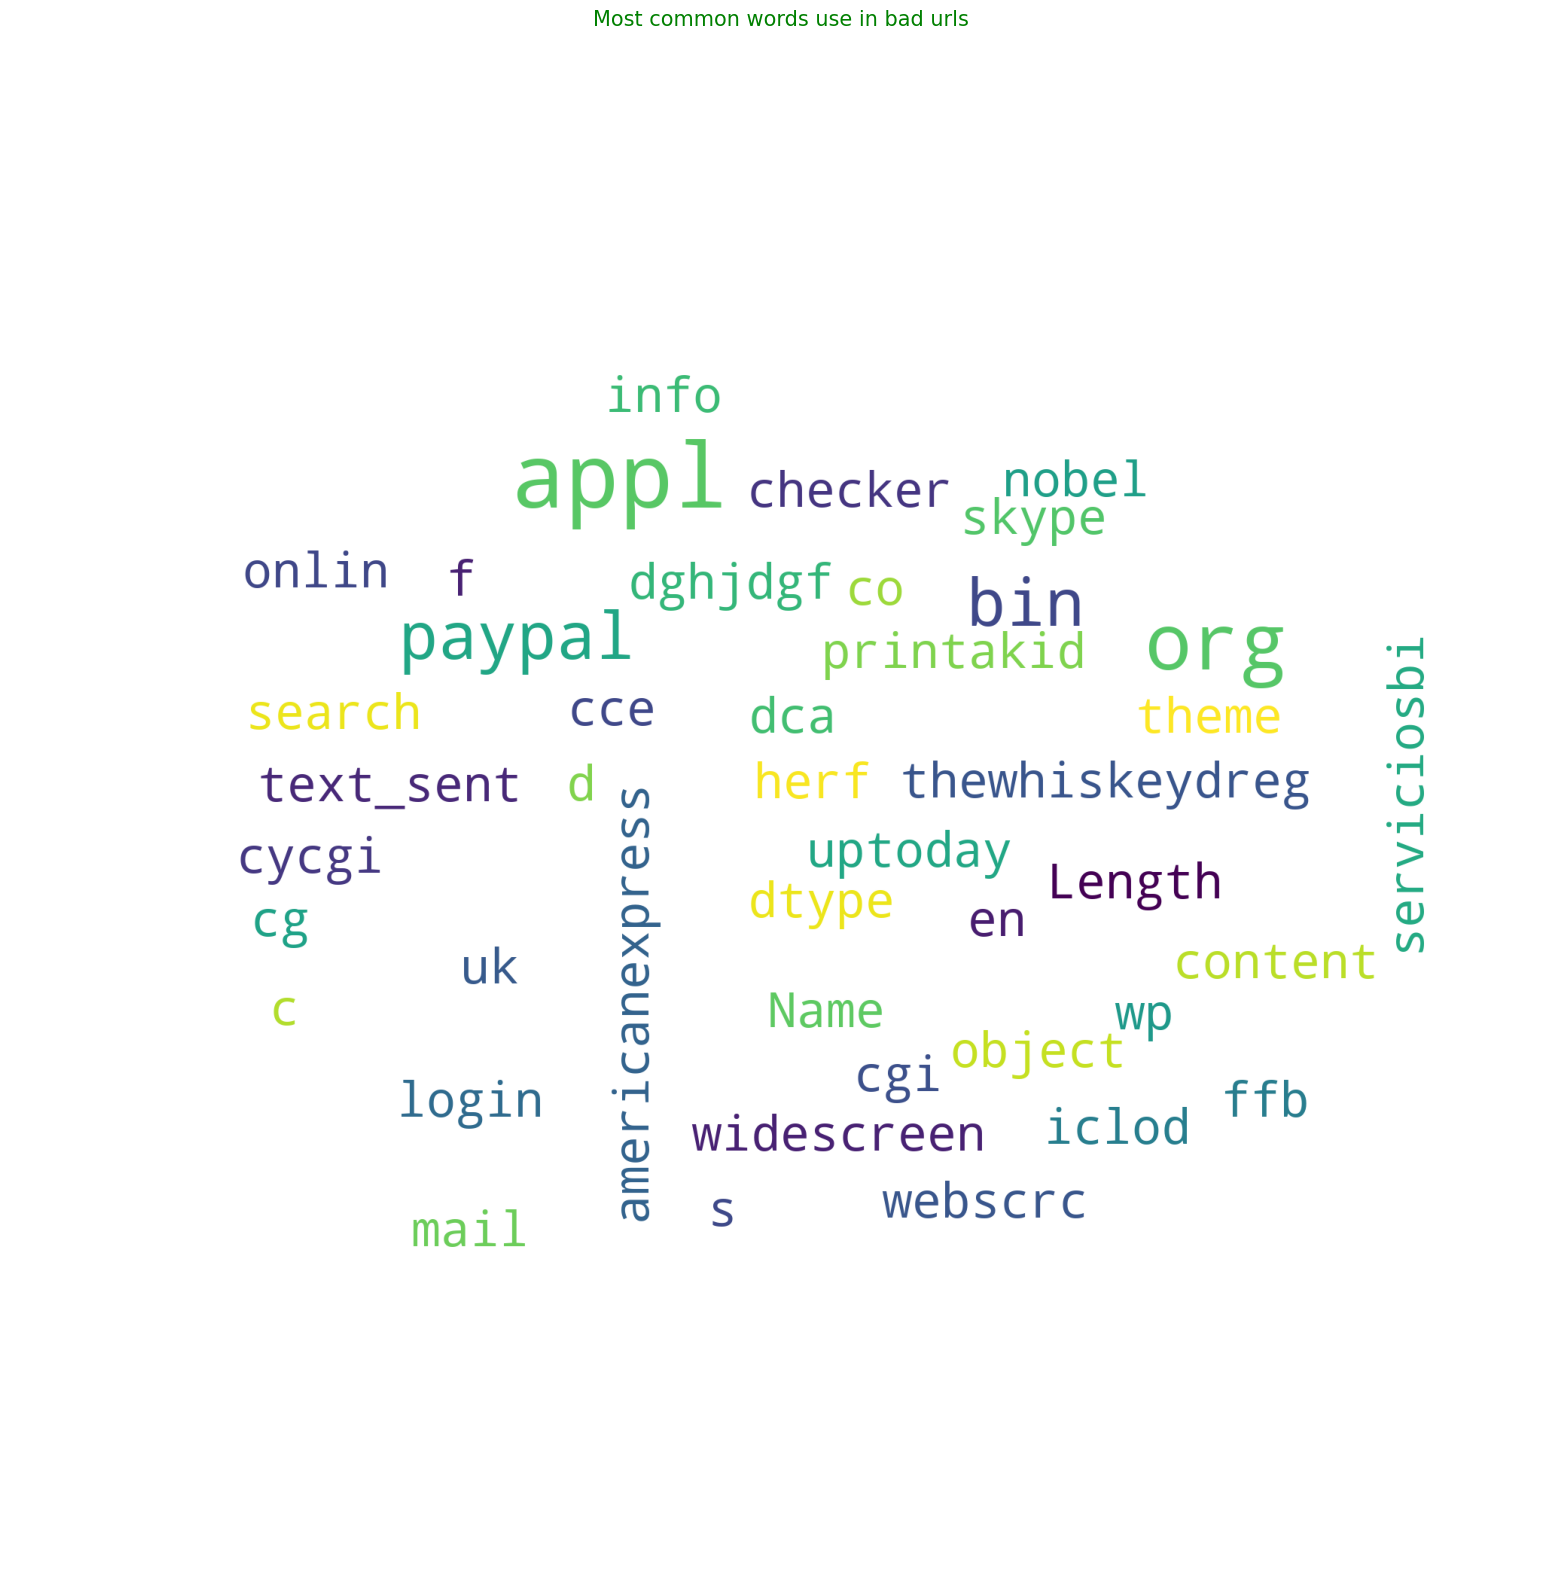

In [ ]:
common_text = str(data)
common_mask = np.array(Image.open('drive/MyDrive/comment.png'))
plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120,
               title = 'Most common words use in bad urls', title_size=15)

**VECTORIZING USING TFIDF**

In [ ]:
word_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features =1000)

unigramdataGet= word_vectorizer.fit_transform(phish_data['text_stemmed'].astype('str'))
unigramdataGet = unigramdataGet.toarray()
vocab = word_vectorizer.get_feature_names_out ()
x=pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)
x[x>0] = 1

In [ ]:
x

,aa,ab,abc,about,absoluteastronomi,abus,ac,access,account,action,...,yellowpag,yelp,york,you,your,youtub,za,zimbio,zip,zoominfo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**CREATING MODEL: COUNTVECTORIZER**

In [ ]:
cv = CountVectorizer()

In [ ]:
feature = cv.fit_transform(phish_data.text_sent)

In [ ]:
feature[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

**SPLITTING THE DATA**

In [ ]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)

In [ ]:
lr = LogisticRegression()

In [ ]:
lr.fit(trainX,trainY)

LogisticRegression()

**LogisticRegression()**

In [ ]:
lr.score(testX,testY)

0.962665320704422

In [ ]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9766690501477407
Testing Accuracy : 0.962665320704422

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.87      0.96      0.91     25938
        Good       0.99      0.96      0.98    100861

    accuracy                           0.96    126799
   macro avg       0.93      0.96      0.94    126799
weighted avg       0.97      0.96      0.96    126799


CONFUSION MATRIX


<Axes: >

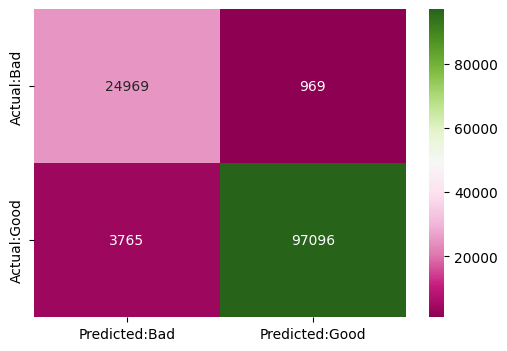

In [ ]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="PiYG")